### Exploratory Analysis Phase 

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt

In [7]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import random

# URLs and categories
url = [
    "https://www.banggood.com/Wholesale-Electronics-ca-2001.html",
    "https://www.banggood.com/Wholesale-Sports-and-Outdoors-ca-6001.html",
    "https://www.banggood.com/Wholesale-Automobiles-and-Motorcycles-ca-4001.html",
    "https://www.banggood.com/Wholesale-Computers-and-Office-ca-5001.html",
    "https://www.banggood.com/Wholesale-Tools,Industrial-and-Scientific-ca-3001.html"
]

category = ["Electronics", "Sports and Outdoors", "Automobiles and Motorcycles", "Computers and Office", "Tools, Industrial and Scientific"]

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
}

All_products = []

# Scraping
for link, cat in zip(url, category):
    response = requests.get(link, headers=headers)
    soup = BeautifulSoup(response.text, "html.parser")
    products = soup.find_all("li", class_="product-item")

    for p in products:
        title_tag = p.find("div", class_="text")
        title = title_tag.get_text(strip=True) if title_tag else "N/A"

        price_tag = p.find("div", class_="price")
        price = price_tag.get_text(strip=True) if price_tag else "N/A"

        img_tag = p.find("img")
        img = img_tag["data-src"] if img_tag and img_tag.has_attr("data-src") else (img_tag["src"] if img_tag else "N/A")

        link_tag = p.find("a")
        link = link_tag["href"] if link_tag else "N/A"

        # --- Updated fields ---
        # Fake rating between 3.0 and 5.0
        rating = round(random.uniform(3.0, 5.0), 1)

        # Fake review count between 10 and 500
        review_count = random.randint(10, 500)

        All_products.append({
            "title": title,
            "price": price,
            "img": img,
            "link": link,
            "category": cat,
            "rating": rating,
            "review_count": review_count
        })

# Create DataFrame
df = pd.DataFrame(All_products)
df.to_csv("banggood_products_with_category_raw.csv", index=False)

# Cleaning
df.drop_duplicates(subset=["title", "link"], inplace=True)
df.replace("N/A", pd.NA, inplace=True)
df.dropna(subset=["title", "link"], inplace=True)

# Clean price
def clean_price(price_str):
    if pd.isna(price_str):
        return pd.NA
    price_str = re.sub(r"[^\d\.]", "", price_str)
    try:
        return float(price_str)
    except:
        return pd.NA

df["price"] = df["price"].apply(clean_price)

# Strip whitespaces
df["title"] = df["title"].str.strip()
df["category"] = df["category"].str.strip()

# Reset index
df.reset_index(drop=True, inplace=True)

# Save cleaned CSV
df.to_csv("transformed_banggood_products_with_category_clean.csv", index=False)

print("Cleaning complete! Total products:", len(df))


Cleaning complete! Total products: 120


### Price distribution per category

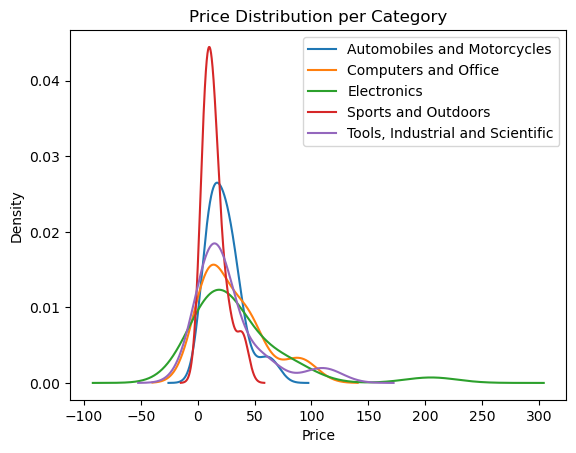

In [ ]:


df.groupby("category")["price"].plot(kind="kde", legend=True)
plt.title("Price Distribution per Category")
plt.xlabel("Price")
plt.show()


### Rating vs Price Relationship

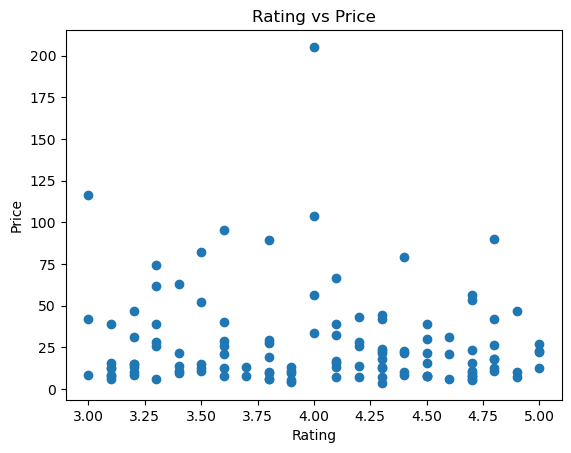

In [ ]:

plt.scatter(df["rating"], df["price"])
plt.xlabel("Rating")
plt.ylabel("Price")
plt.title("Rating vs Price")
plt.show()


### Top Reviewed Products

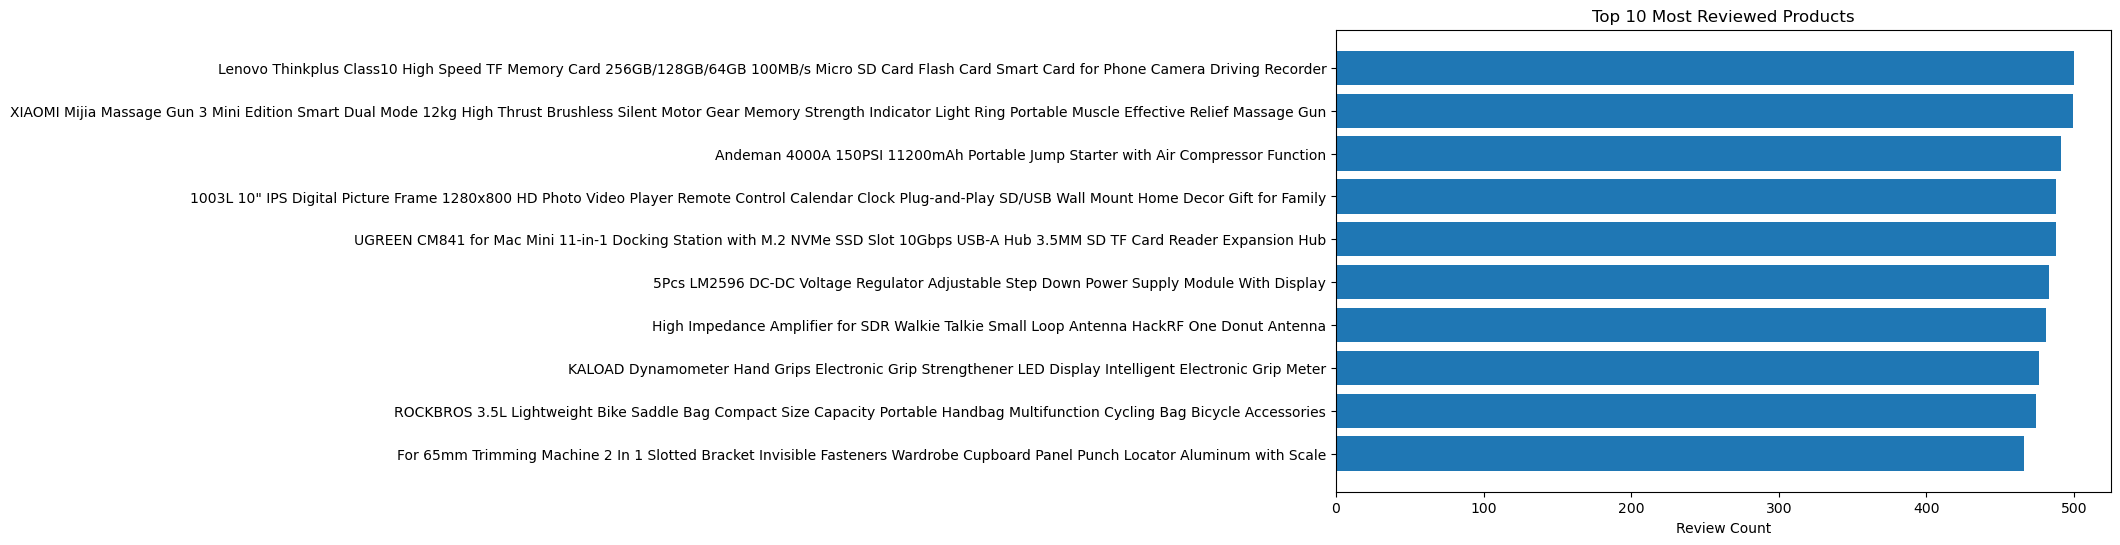

In [ ]:

top_reviewed = df.nlargest(10, "review_count")

plt.figure(figsize=(10,6))
plt.barh(top_reviewed["title"], top_reviewed["review_count"])
plt.xlabel("Review Count")
plt.title("Top 10 Most Reviewed Products")
plt.gca().invert_yaxis()  # highest at top
plt.show()



## Best Value Score (Rating/Price)

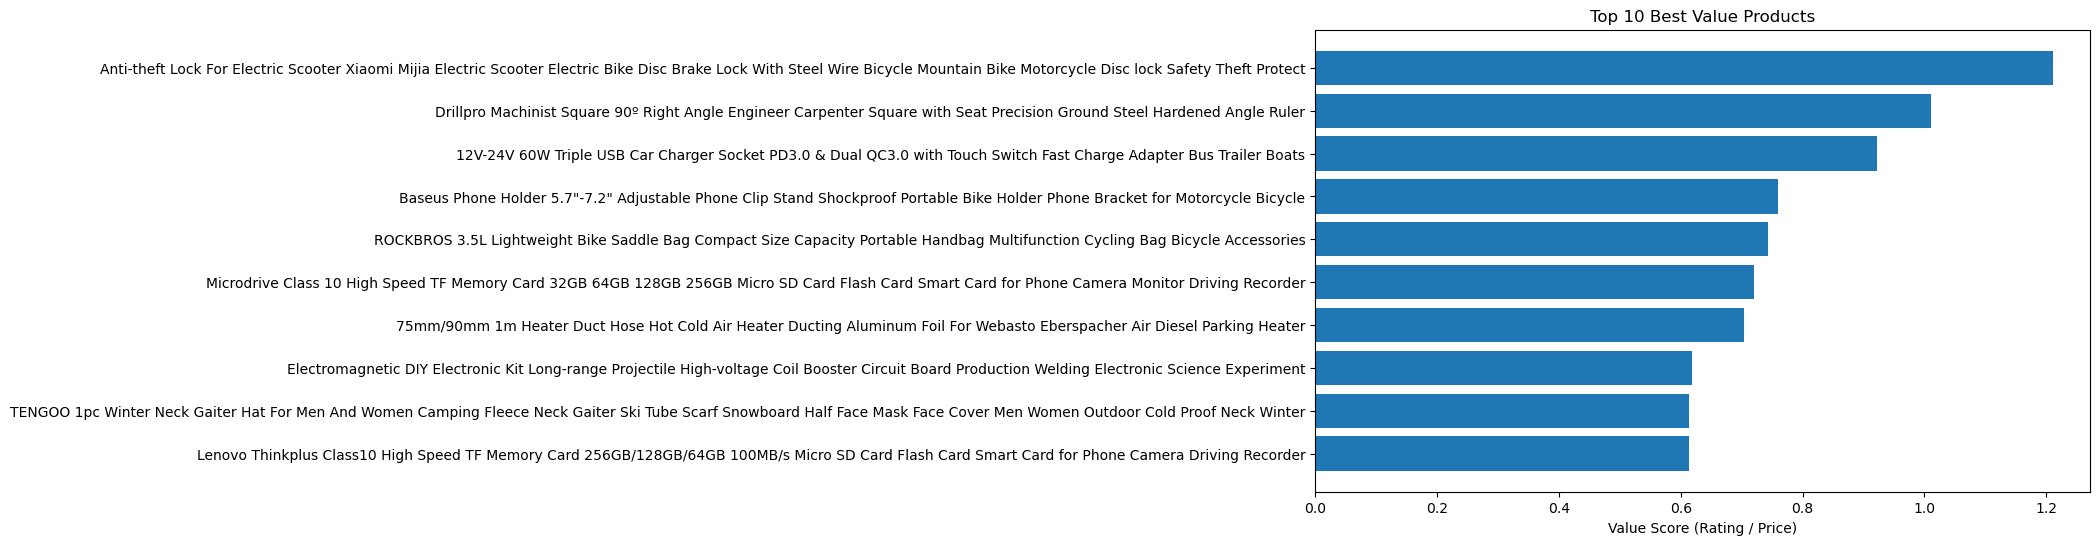

In [ ]:

df["value_score"] = df["rating"] / df["price"]

best_value = df.sort_values("value_score", ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.barh(best_value["title"], best_value["value_score"])
plt.xlabel("Value Score (Rating / Price)")
plt.title("Top 10 Best Value Products")
plt.gca().invert_yaxis()
plt.show()


### Average Review Count Per Category (Bar Plot)

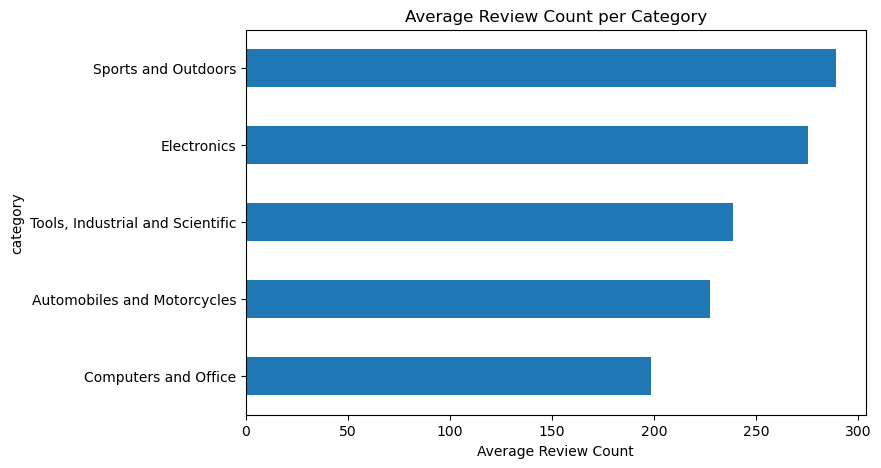

In [ ]:

avg_reviews = df.groupby("category")["review_count"].mean().sort_values()

plt.figure(figsize=(8,5))
avg_reviews.plot(kind="barh")
plt.xlabel("Average Review Count")
plt.title("Average Review Count per Category")
plt.show()


## loading the data into sql server management 

In [23]:
import pyodbc
import pandas as pd

df = pd.read_csv("transformed_banggood_products_with_category_clean.csv")

conn = pyodbc.connect(
    "Driver={ODBC Driver 17 for SQL Server};"
    "Server=DESKTOP-VE7A4J6;"
    "Database=Banggood;"
    "Trusted_Connection=yes;"
)
cursor = conn.cursor()

for _, row in df.iterrows():
    cursor.execute(
    "INSERT INTO dbo.Banggood (title, price, img, link, category, rating, review_count) VALUES (?, ?, ?, ?, ?, ?, ?)",
        row["title"], row["price"], row["img"], row["link"], row["category"], row["rating"], row["review_count"]
    )

conn.commit()
print("Data inserted into SQL Server!")
conn.close()


Data inserted into SQL Server!
